In [1]:
from src.core.negotiation.price_tracker import PriceTracker
from src.core.util import read_json
from src.analysis.negotiation.dialogue import Dialogue
from src.analysis.negotiation.analyze_strategy import StrategyAnalyzer
from src.core.entity import is_entity
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(font_scale=2)
from collections import defaultdict

import warnings
warnings.filterwarnings('ignore')

price_tracker_path = '/scr/hehe/game-dialogue/price_tracker.pkl'
liwc_path = 'data/liwc.pkl'

### Load 10x5 chats

In [2]:
analyzer = StrategyAnalyzer(['web_output/analysis/transcripts/transcripts.json'], ['web_output/analysis/transcripts/surveys.json'], 'stats.json', price_tracker_path, liwc_path, None)
analyzer.label_dialogues(labels=('liwc', 'stage', 'speech_act'))

### Load 1x50 chats

In [2]:
analyzer = StrategyAnalyzer(['web_output/analysis2/transcripts/transcripts.json'], 'stats.json', price_tracker_path, liwc_path, None)
analyzer.label_dialogues(labels=('liwc', 'stage', 'speech_act'))

# of ties: 0
Total chats with outcomes: 44


In [2]:
analyzer = StrategyAnalyzer(['web_output/analysis/transcripts/transcripts.json'], ['web_output/2017-08-15-rule/transcripts/surveys.json'], 'stats.json', price_tracker_path, liwc_path, None)

In [3]:
analyzer.summarize_tags()

KeyError: 1

### Load all chats

In [11]:
dataset = ('combined', 'analysis', 'analysis2')
transcripts = ['web_output/{}/transcripts/transcripts.json'.format(x) for x in dataset]
surveys = ['web_output/{}/transcripts/surveys.json'.format(x) for x in dataset]
analyzer = StrategyAnalyzer(transcripts, surveys, 'stats.json', price_tracker_path, liwc_path, None)
#analyzer.label_dialogues(labels=('liwc', 'stage', 'speech_act'))

### Create dataframe

In [12]:
df = analyzer.create_dataframe()
df = df[df['margin_buyer'].abs() < 2.5]
print len(df)

75814


In [159]:
df = df.groupby('scenario_id').filter(lambda x: len(x['chat_id'].unique()) > 2)
print len(df)

7650


Label good/bad buyer/seller by margin, optionally normalized by scenario.

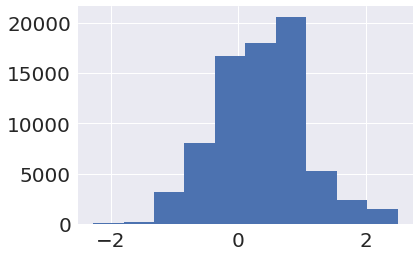

In [13]:
zscore = lambda x: (x - x.mean()) / x.std()
demean = lambda x: x - x.mean()
original = lambda x: x

normalized_margin = df.groupby('scenario_id')['margin_buyer'].transform(original)
plt.hist(normalized_margin)
ngroups = 4
middle = range(ngroups - 2)
c = pd.qcut(normalized_margin.abs(), ngroups, labels=['fair'] + middle + ['biased'])
df['label_fairness'] = c
c = pd.qcut(normalized_margin, ngroups, labels=['bad'] + middle + ['good'])
df['label_buyer'] = c
c = pd.qcut(normalized_margin*-1., ngroups, labels=['bad'] + middle + ['good'])
df['label_seller'] = c

### Plot seller margin vs buyer target

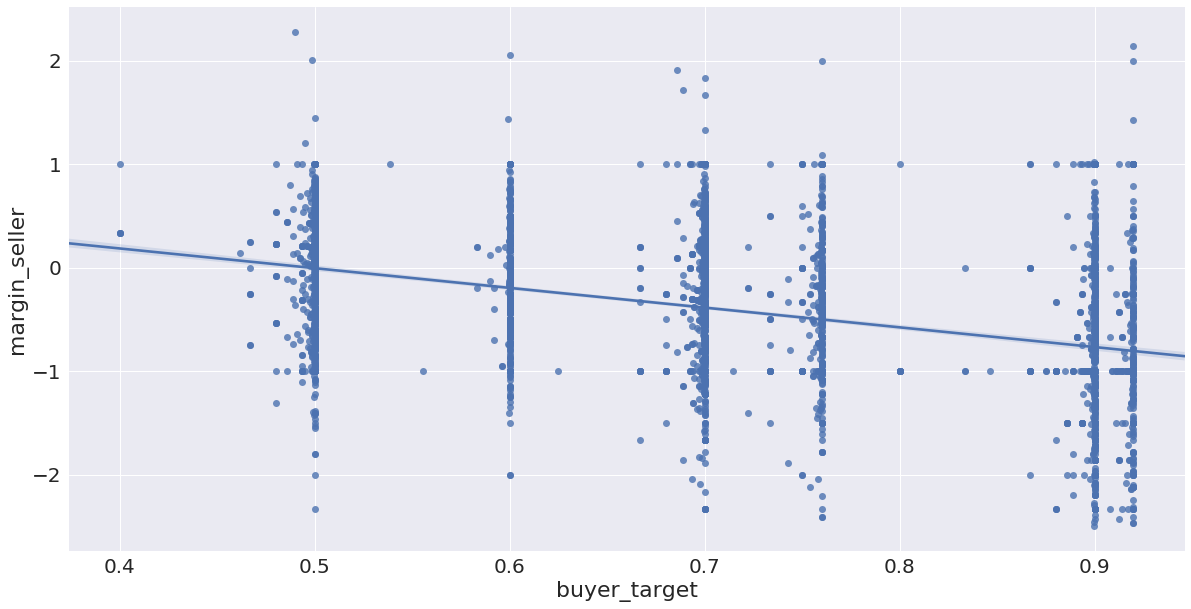

In [6]:
d = df[['chat_id', 'scenario_id', 'post_id', 'margin_seller', 'buyer_target', 'margin_buyer', 'listing_price']]
d = d.groupby('chat_id').apply(lambda x: x.head(1))
d['buyer_target'] /= d['listing_price']
plt.figure(figsize=(20,10))
sns.regplot(x='buyer_target', y='margin_seller', data=d)

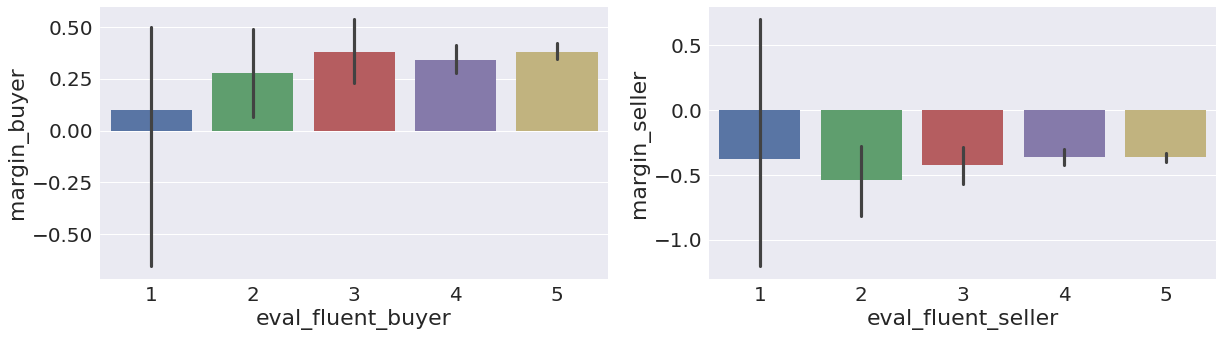

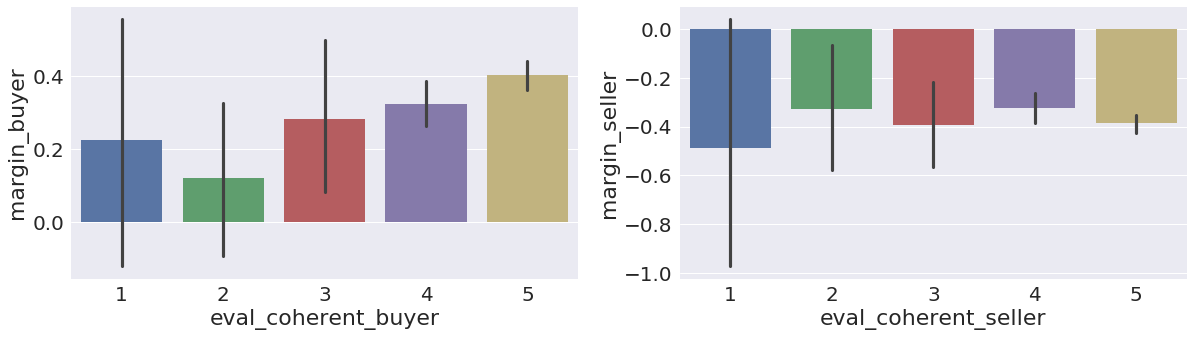

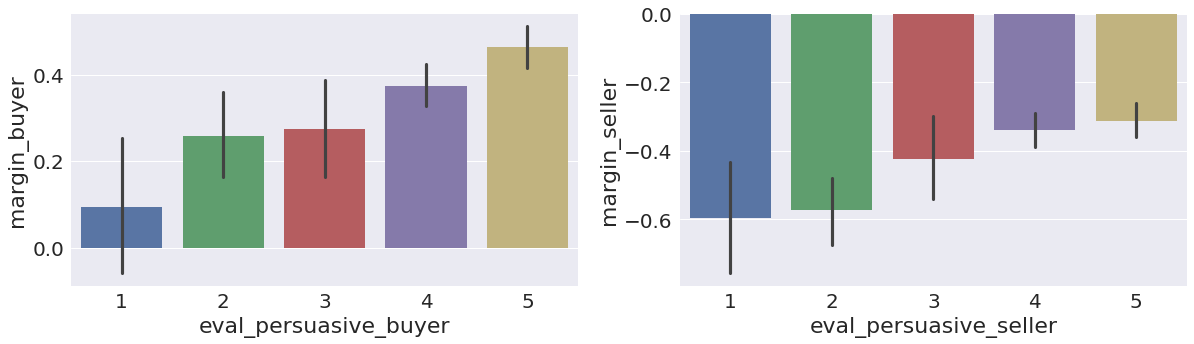

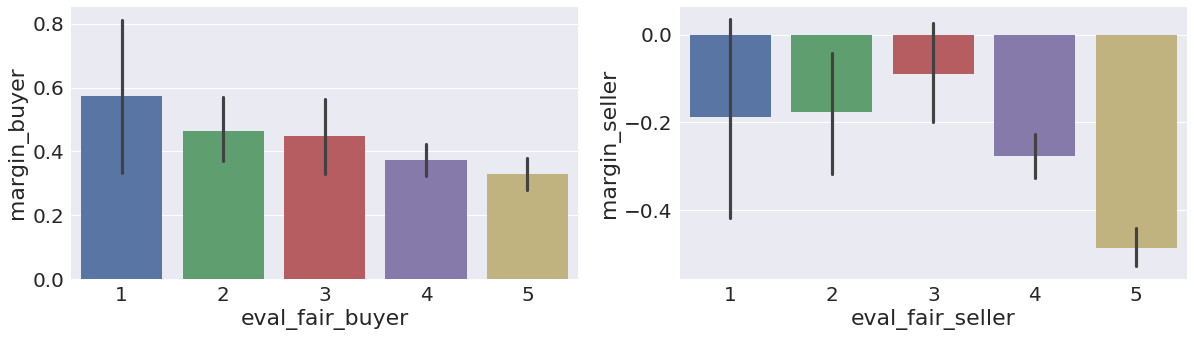

In [29]:
eval_cols = ['eval_{question}_{role}'.format(question=q, role=r) for r in ('buyer', 'seller') for q in Dialogue.eval_questions]
d = df.loc[df['eval_persuasive_seller'] != -1][['chat_id', 'margin_seller', 'margin_buyer'] + eval_cols]
for q in Dialogue.eval_questions:
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))
    for i, r in enumerate(('buyer', 'seller')):
        col = 'eval_{question}_{role}'.format(question=q, role=r)
        d = d[d[col] != -1].groupby('chat_id').apply(lambda x: x.head(1))
        g = sns.barplot(ax=axes[i], x=col, y='margin_{}'.format(r), data=d)

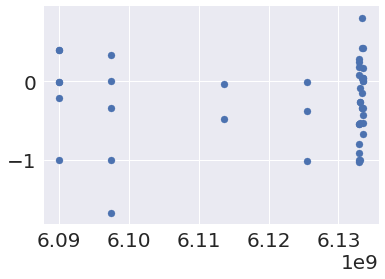

In [22]:
plt.scatter(x=d['post_id'], y=d['margin_seller'])

### Anaylze fairness (abosulute margin: 0 is the most fair result, >=1 is skewed result).

5292


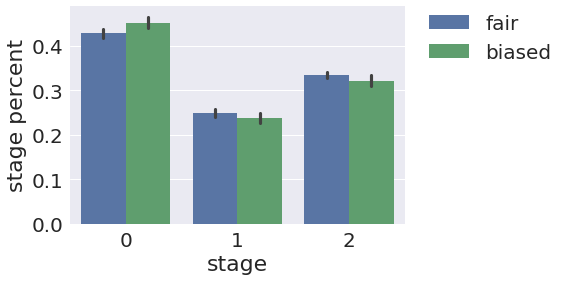

In [21]:
d = df[(df[('label', 'fairness')]=='fair') | (df[('label', 'fairness')]=='biased')]
dd = d.groupby(['chat_id', ('label', 'fairness')])['stage'].value_counts(normalize=True).reset_index(name='stage percent')
print len(dd)
#sns.countplot(x='stage', data=d, hue=('label', 'fairness'), hue_order=['fair', 'biased'])
sns.barplot(x='stage', y='stage percent', data=dd, hue=('label', 'fairness'), hue_order=['fair', 'biased'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### Anaylze time spent in each stage by good/bad sellers.

38278 2313


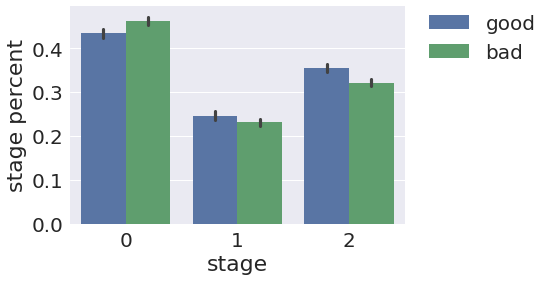

In [22]:
role = 'seller'
d = df[(df[('label', role)]=='bad') | (df[('label', role)]=='good')]
print len(d), len(d.chat_id.unique())
dd = d.groupby(['chat_id', ('label', role)])['stage'].value_counts(normalize=True).reset_index(name='stage percent')

#sns.countplot(x='stage', data=d, hue=('label', role), hue_order=['good', 'bad'])
sns.barplot(x='stage', y='stage percent', data=dd, hue=('label', role), hue_order=['good', 'bad'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Prepare data for speech acts and LIWC analysis.

In [23]:
data = {}
for i, role in enumerate(('seller', 'buyer')):
    d = df[((df[('label', role)]=='good') | (df[('label', role)]=='bad')) & (df.role == role)]
    d[('act', 'price_question')] = d.apply(lambda row: 1 if row[('act', 'question')] == 1 and row[('act', 'price')] == 1 else 0, axis=1)
    d[('act', 'price_statement')] = d.apply(lambda row: 1 if row[('act', 'question')] == 0 and row[('act', 'price')] == 1 else 0, axis=1)
    d[('cat', 'humans')] = d[('cat', 'humans')] + d[('cat', 'family')] + d[('cat', 'friend')]
    data[role] = d
    print len(d), len(d['chat_id'].unique())

19059 2313
14367 1700


### number of tokens per chat, over stages.

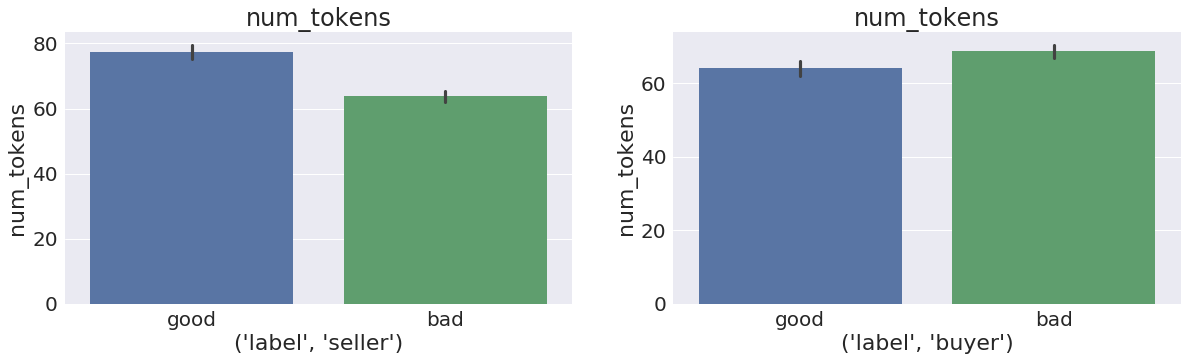

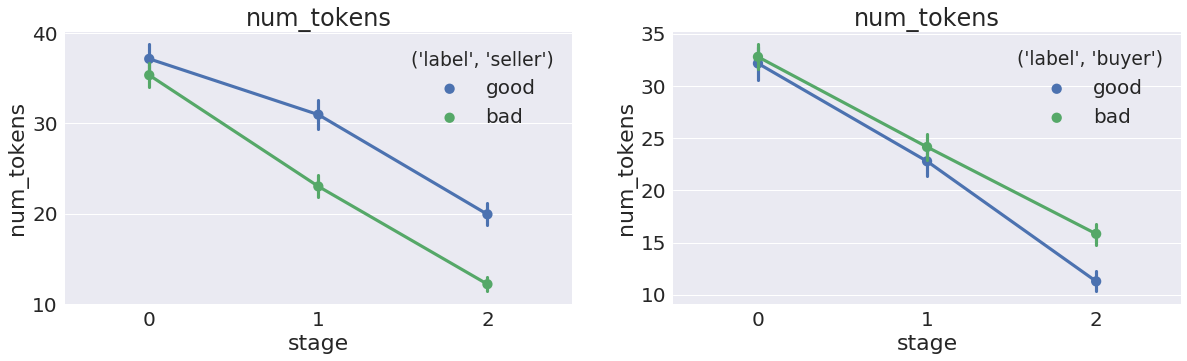

In [24]:
def plot_good_vs_bad(data, cols, by_stage=False, normalization=None):
    by = lambda r: ['chat_id', 'stage', ('label', r)] if by_stage else ['chat_id', ('label', r)]
    groups = {r: data[r].groupby(by(r)) for r in ('seller', 'buyer')}
    dd = {}
    for i, role in enumerate(('seller', 'buyer')):
        agg_func = lambda x: np.sum(x)
        
        if normalization == 'utterance':
            agg_func = lambda x: np.sum(x) / float(len(x))
        col_agg_func = {col: agg_func for col in cols}
        if normalization == 'token':
            col_agg_func['num_tokens'] = lambda x: np.sum(x)
            
        d = groups[role].agg(col_agg_func).reset_index()
        
        if normalization == 'token':
            for col in cols:
                d[col] /= d['num_tokens']
                
        dd[role] = d
        
    for j, col in enumerate(cols):
        fig, axes = plt.subplots(1, 2, figsize=(20, 5))
        for i, role in enumerate(('seller', 'buyer')):
            ax = axes[i]           
            if not by_stage:
                g = sns.barplot(ax=ax, data=dd[role], y=col, x=('label', role), order=['good', 'bad'])
            else:
                g = sns.factorplot(ax=ax, data=dd[role], x='stage', y=col, hue=('label', role), hue_order=['good', 'bad'])
                plt.close(g.fig)
            ax.set_title(str(col))

cols = ['num_tokens']
plot_good_vs_bad(data, cols, by_stage=False, normalization=None)
plot_good_vs_bad(data, cols, by_stage=True, normalization=None)

### % of LIWC categories of the entire chat.

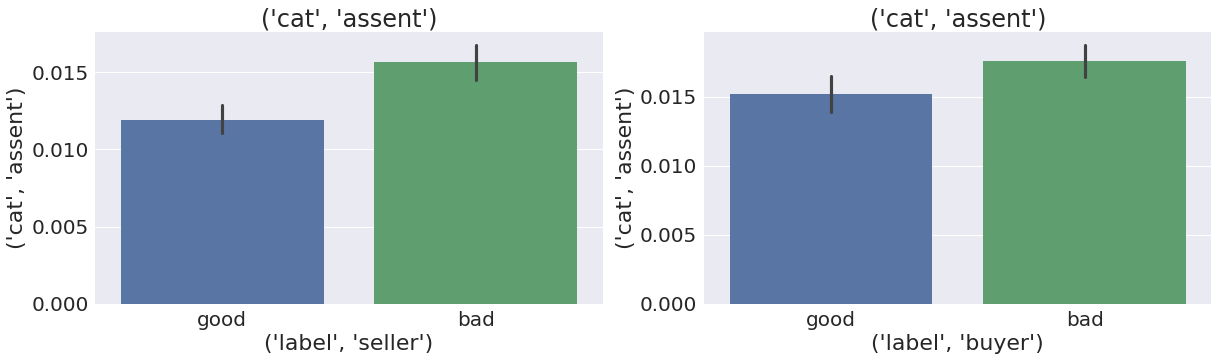

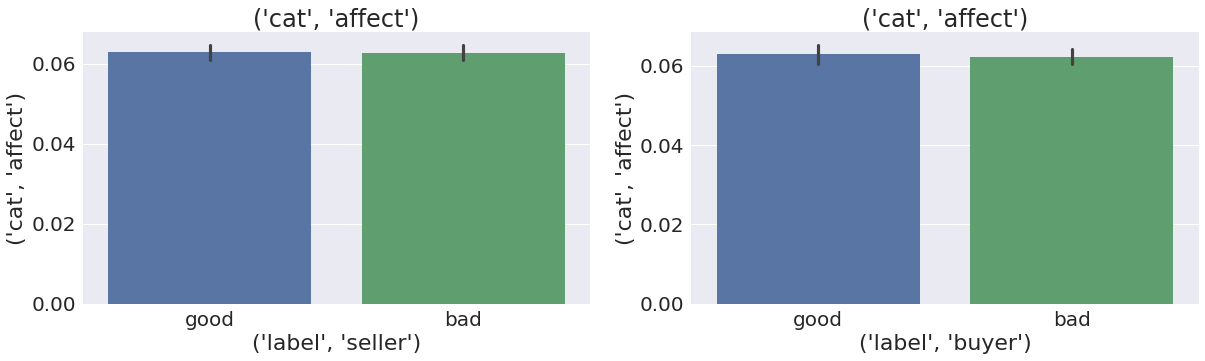

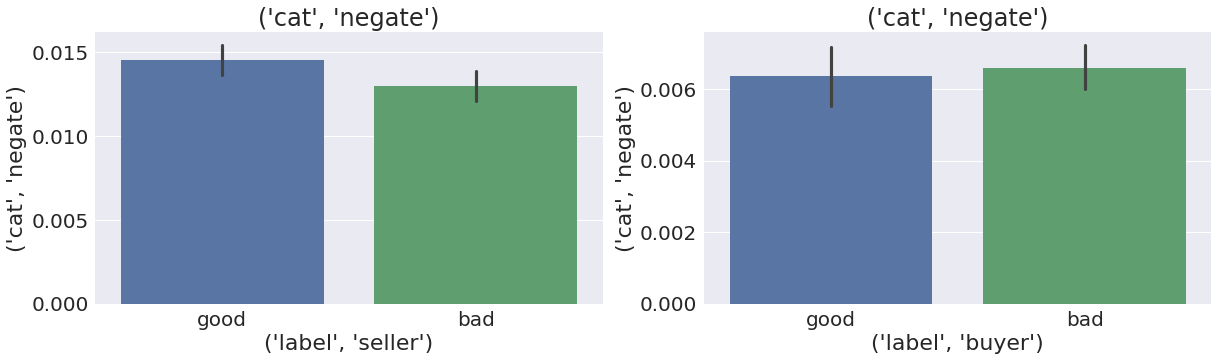

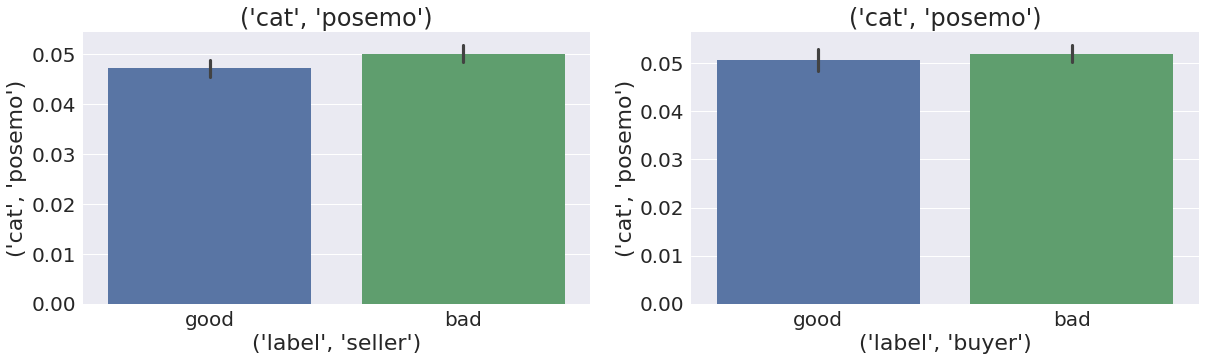

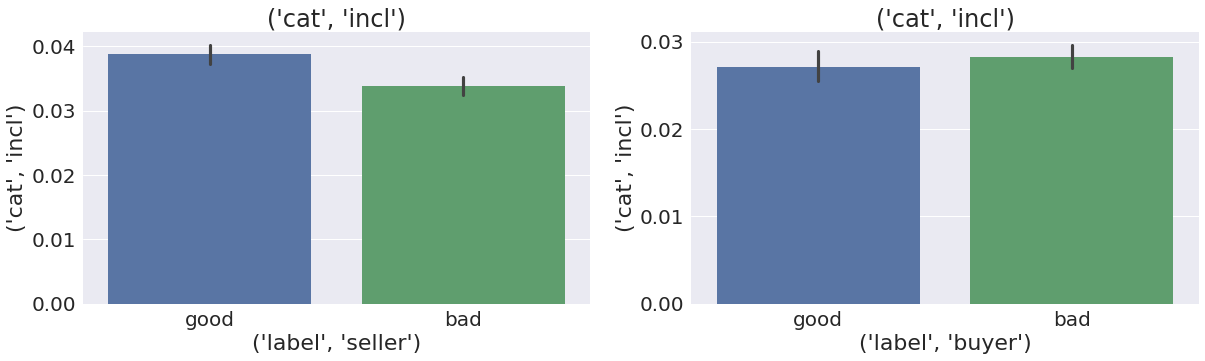

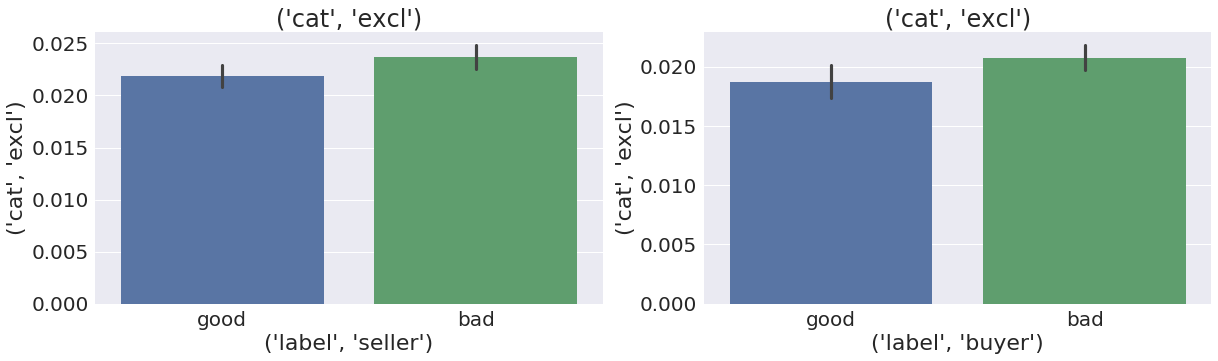

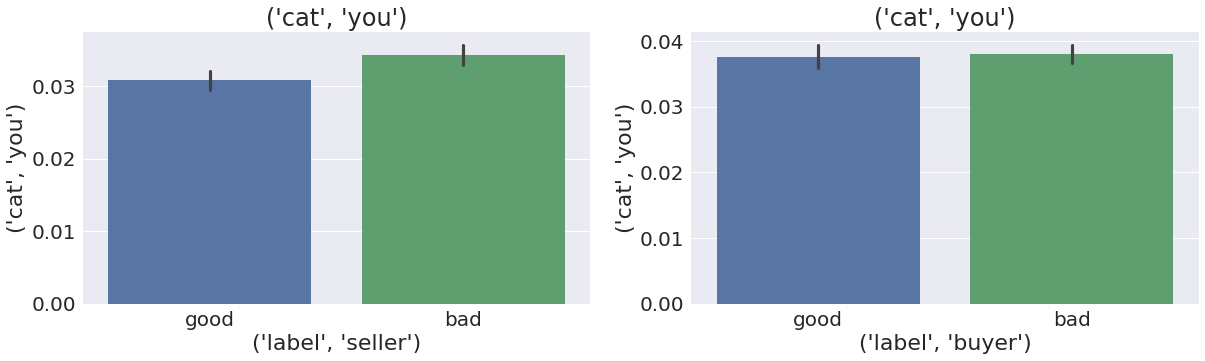

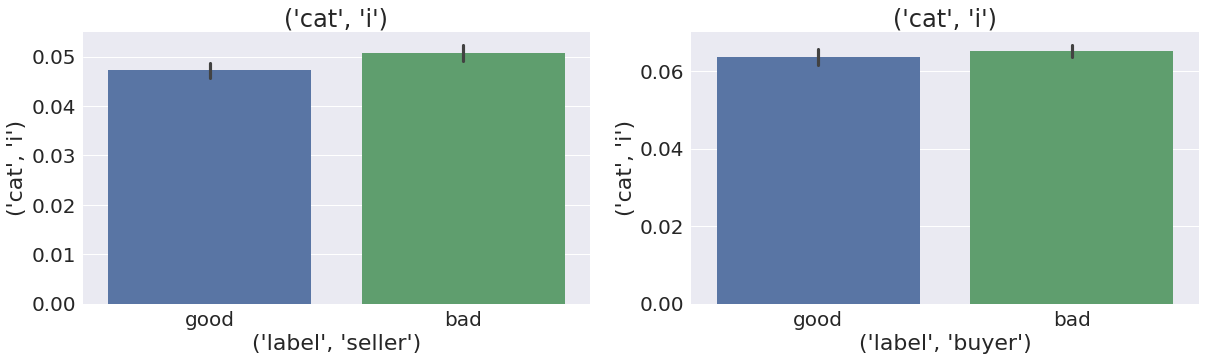

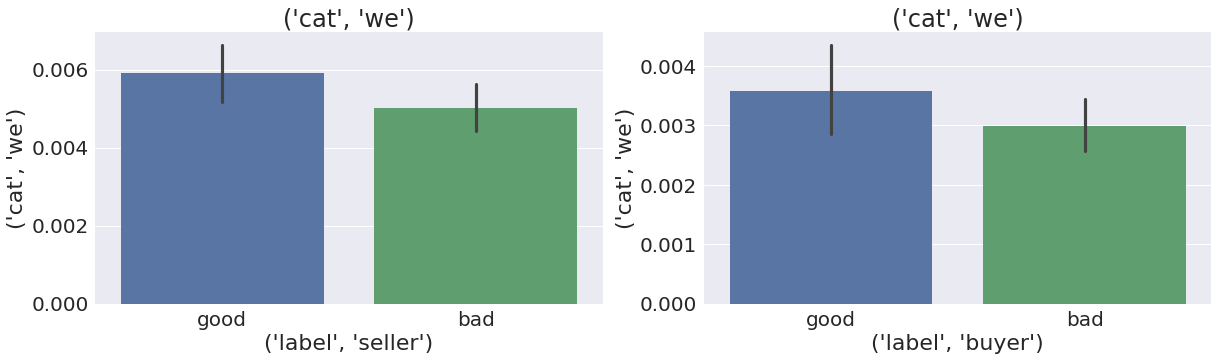

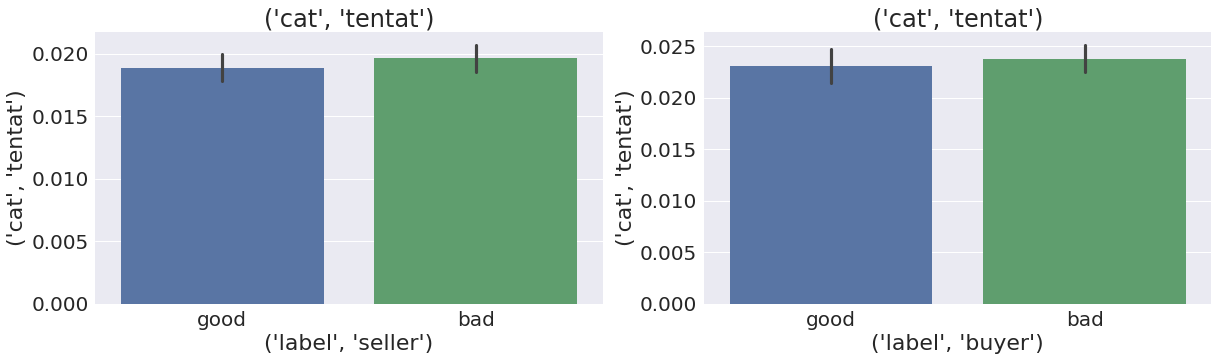

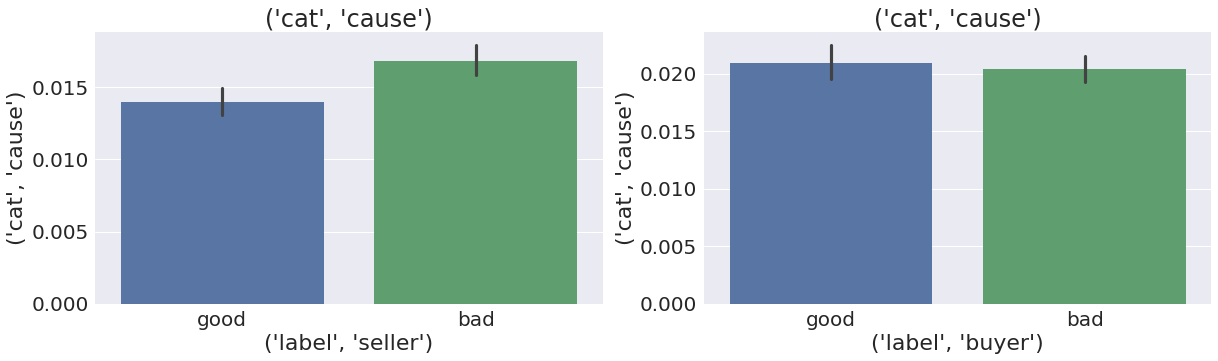

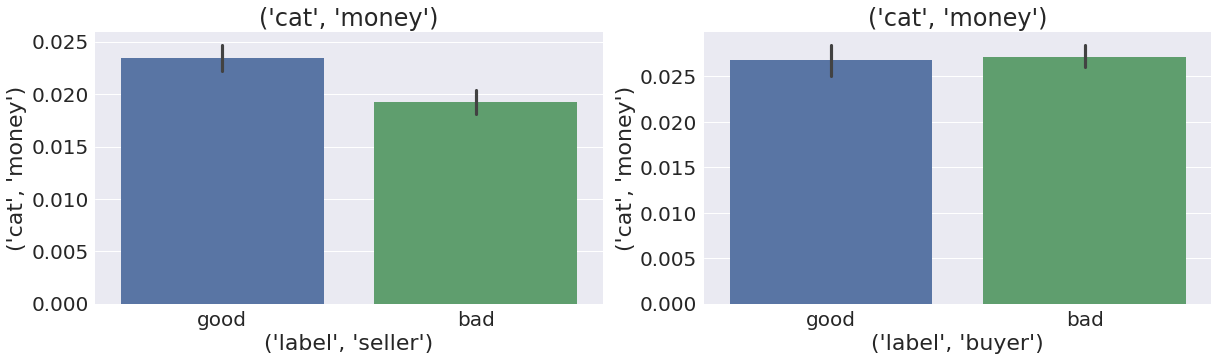

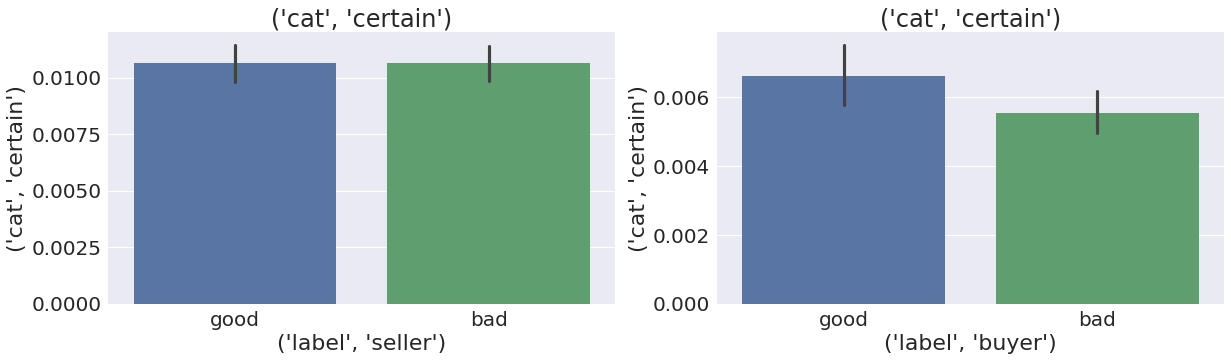

In [25]:
cats=['assent', 'affect', 'negate', 'posemo', 'incl', 'excl', 'you', 'i', 'we', 'tentat', 'cause', 'money', 'certain']
cats = [('cat', c) for c in cats]
plot_good_vs_bad(data, cats, by_stage=False, normalization='token')

### % of LIWC categories over stages.

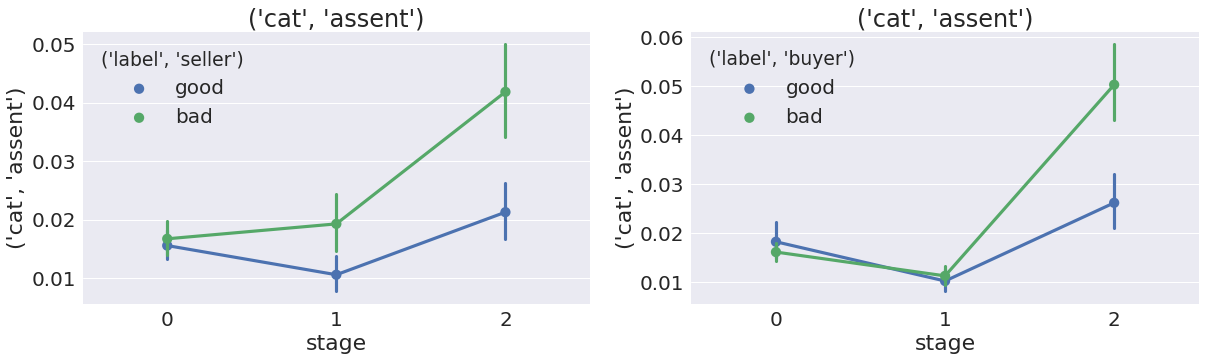

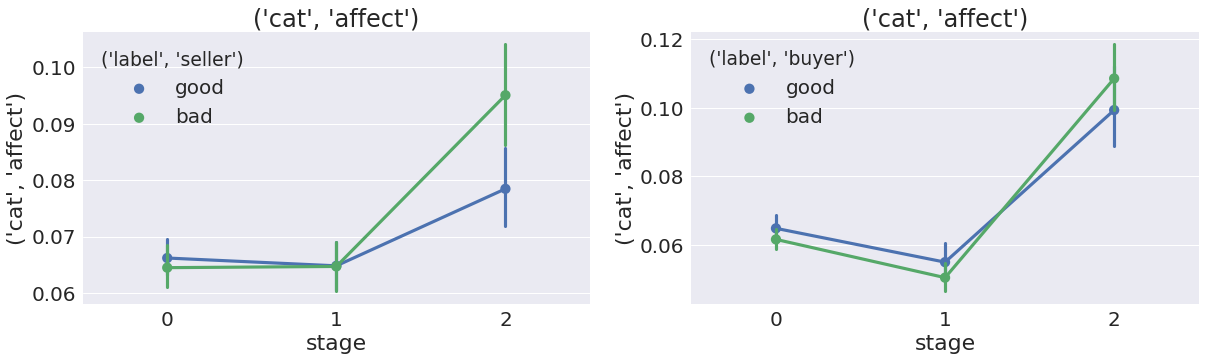

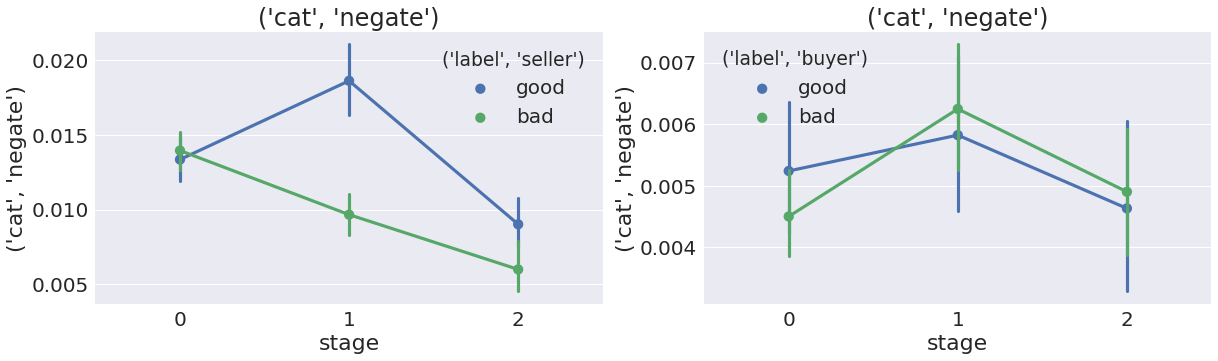

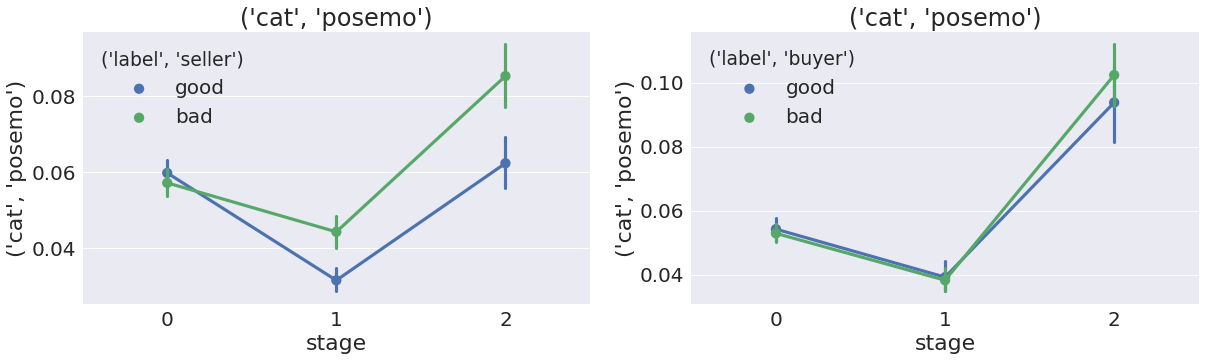

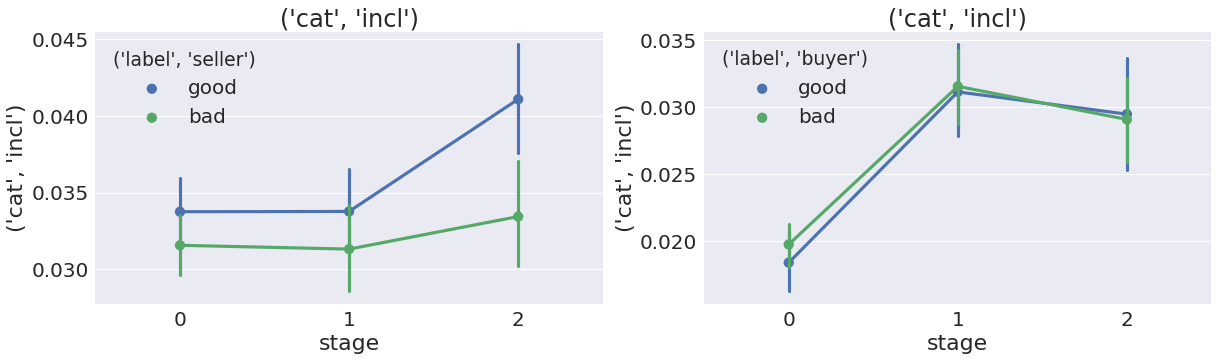

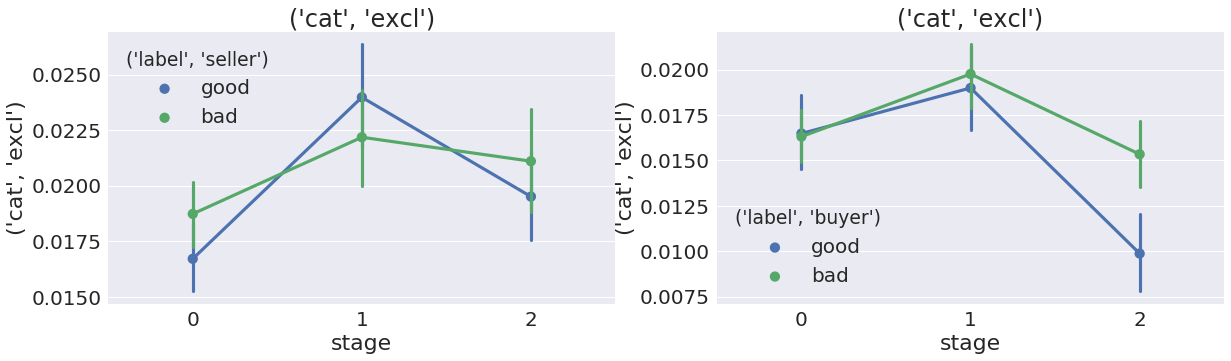

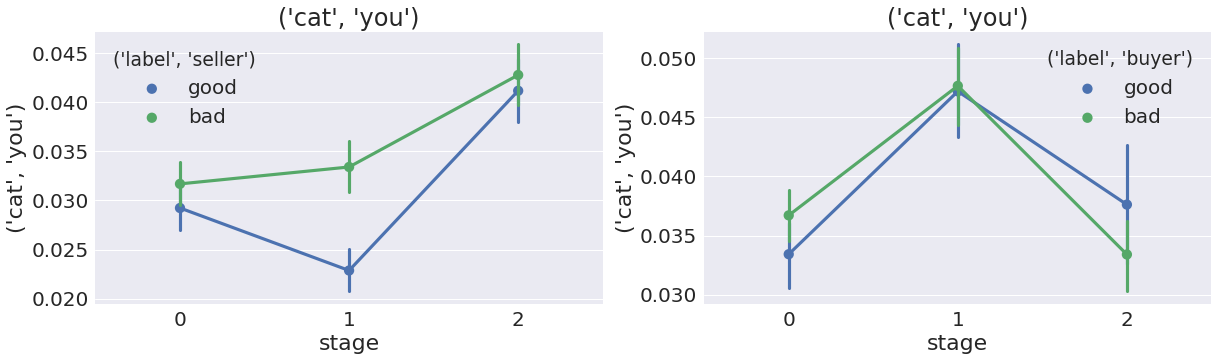

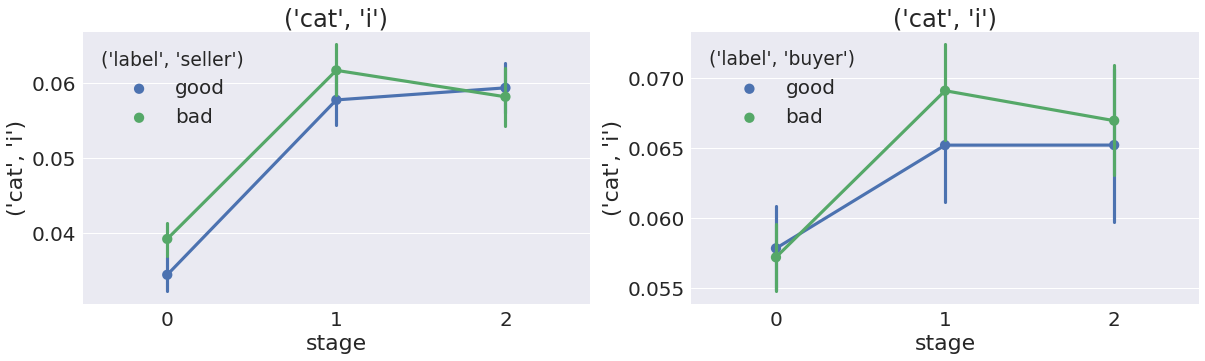

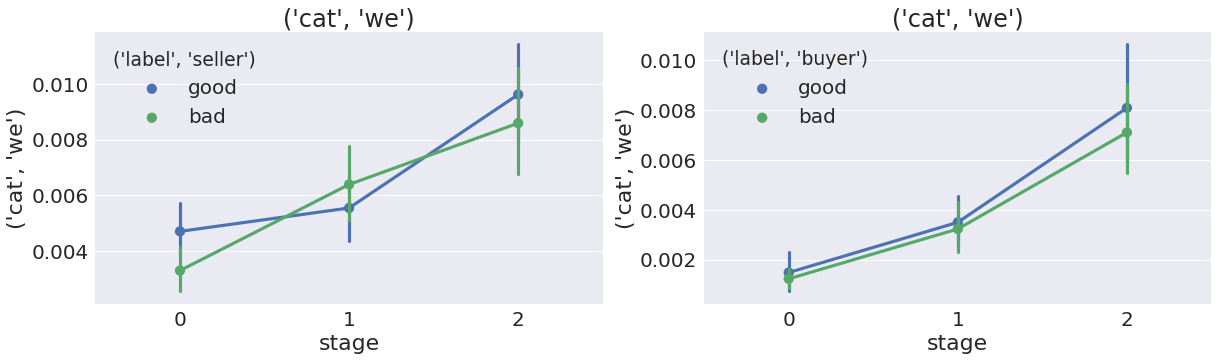

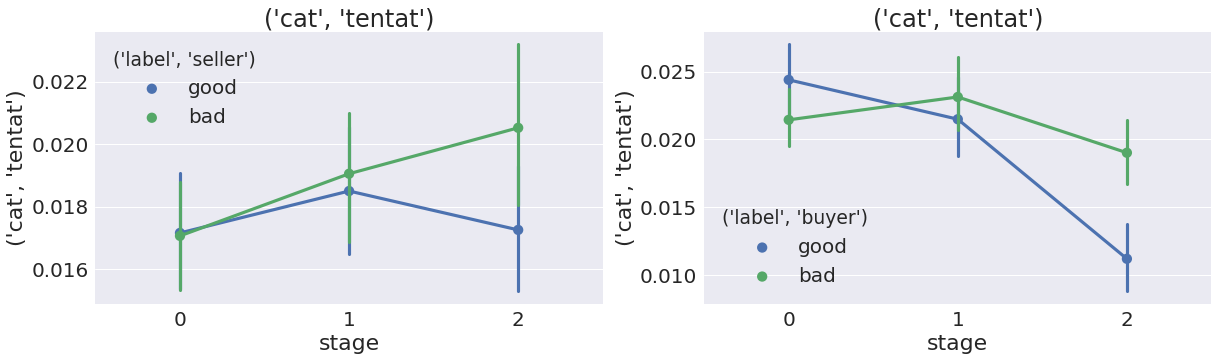

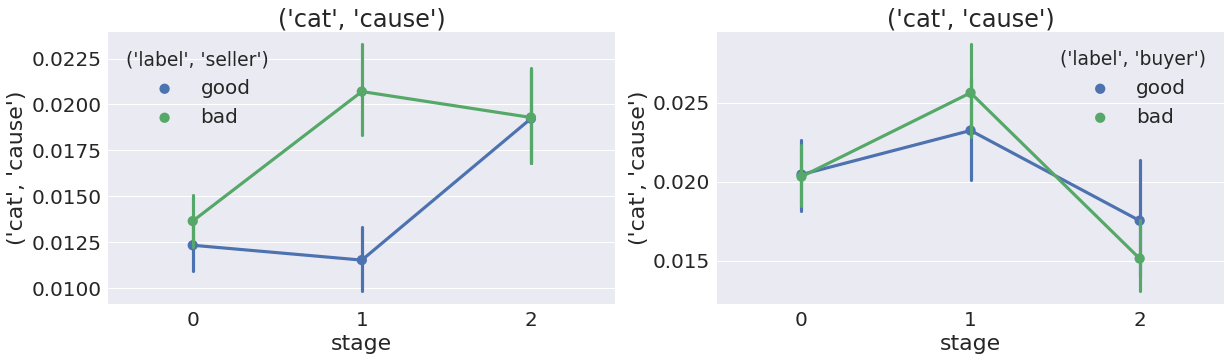

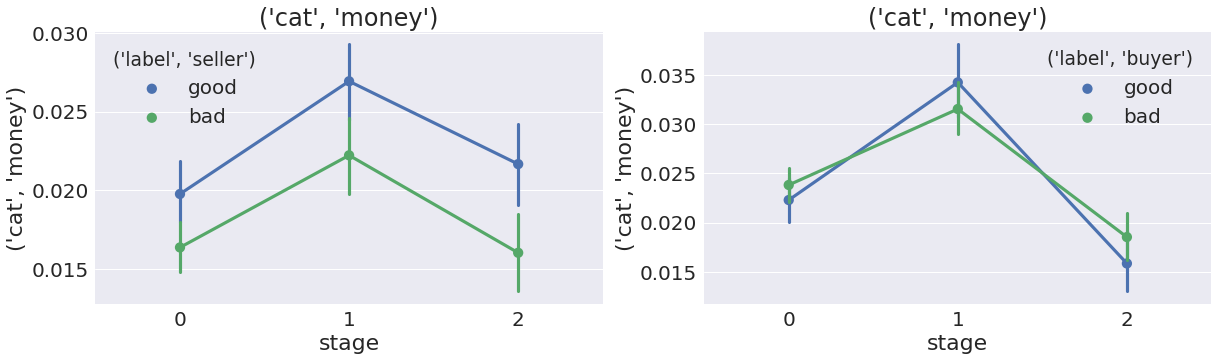

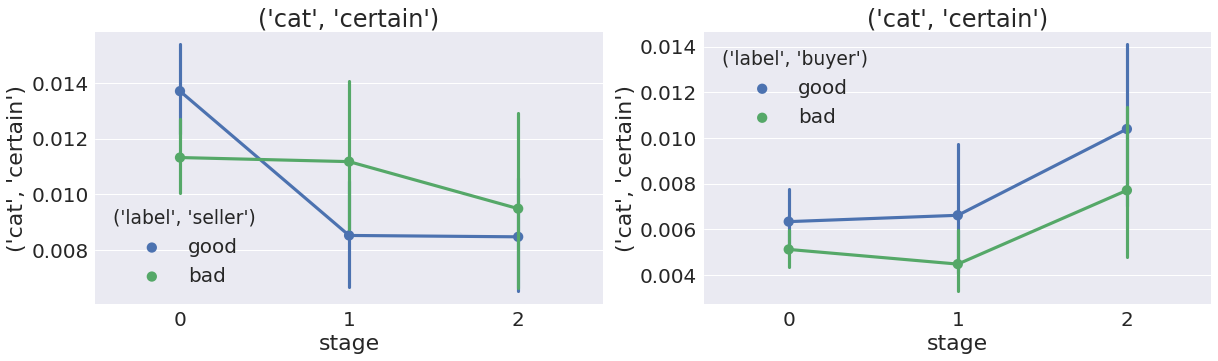

In [26]:
plot_good_vs_bad(data, cats, by_stage=True, normalization='token')

In [33]:
def print_top_word(dialogues, chat_ids, cats, k=10):
    dialogues = {d.chat_id: d for d in dialogues}
    categories = defaultdict(lambda : defaultdict(int))
    for chat_id in chat_ids:
        for u in dialogues[chat_id].iter_utterances():
            for cat, word_count in u.categories.iteritems():
                if cat in cats:
                    for word, count in word_count.iteritems():
                        categories[cat][word] += count
    def topk(word_counts, k=10):
        wc = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)[:k]
        return [w[0] for w in wc]
    for cat, word_count in categories.iteritems():
        print cat.upper(), topk(word_count, k)

roles = ['seller']
cats = ['assent', 'negate', 'posemo', 'incl', 'money', 'cause']
stage = 1
for role in roles:
    dd = data[role]
    for label in ('good', 'bad'):
        print 'LABEL:', label
        chat_ids = dd.loc[(df[('label', role)] == label)]['chat_id']
        print_top_word(analyzer.examples, chat_ids, cats, k=20)

LABEL: good
CAUSE ['how', 'pick', 'used', 'make', 'since', 'because', 'use', 'why', 'reasonable', 'made', 'reason', 'makes', 'change', 'allow', 'making', 'changed', 'product', "how's", 'allowed', 'justify']
POSEMO ['great', 'interested', 'good', 'well', 'ok', 'okay', 'sure', 'accept', 'thanks', 'nice', 'thank', 'love', 'awesome', 'free', 'excellent', 'pretty', 'perfect', 'fine', 'please', 'beautiful']
ASSENT ['yes', 'ok', 'okay', 'oh', 'awesome', 'yeah', 'alright', 'hmm', 'agree', 'absolutely', 'cool', 'lol', 'hmmm', 'yep', 'yea', 'haha', 'ah', 'hm', 'yup', 'hmmmm']
MONEY ['price', 'pay', 'cash', 'rent', 'selling', 'sell', 'buy', 'budget', 'free', 'deposit', 'lease', 'sale', 'money', 'worth', 'bought', 'cost', 'dollars', 'buying', 'discount', 'spend']
NEGATE ['not', 'no', "can't", "don't", 'never', "won't", "doesn't", 'without', 'nothing', "didn't", 'dont', 'cant', "isn't", 'nope', "wouldn't", "couldn't", "haven't", "aren't", 'none', 'wont']
INCL ['and', 'with', 'we', 'come', 'out', 'i

### % of speech acts per chat.

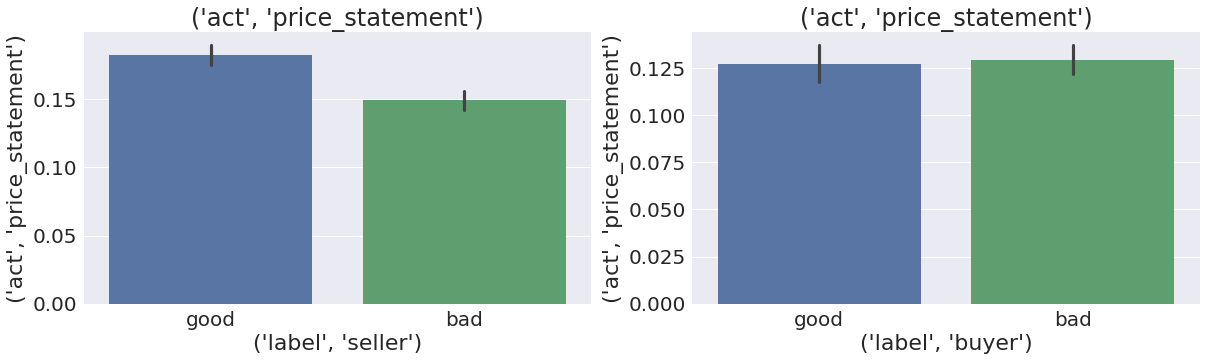

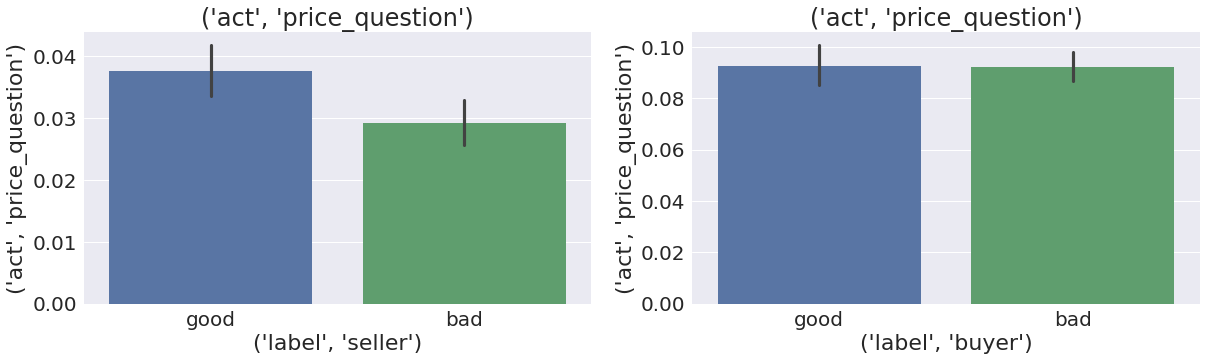

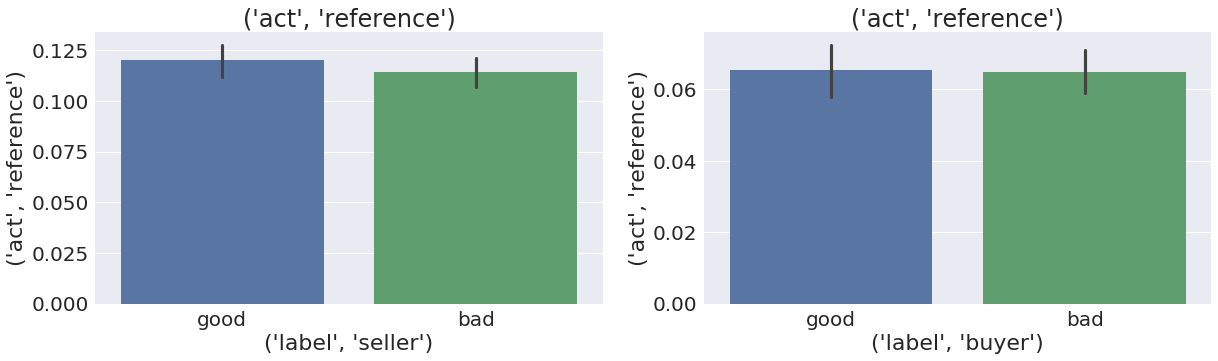

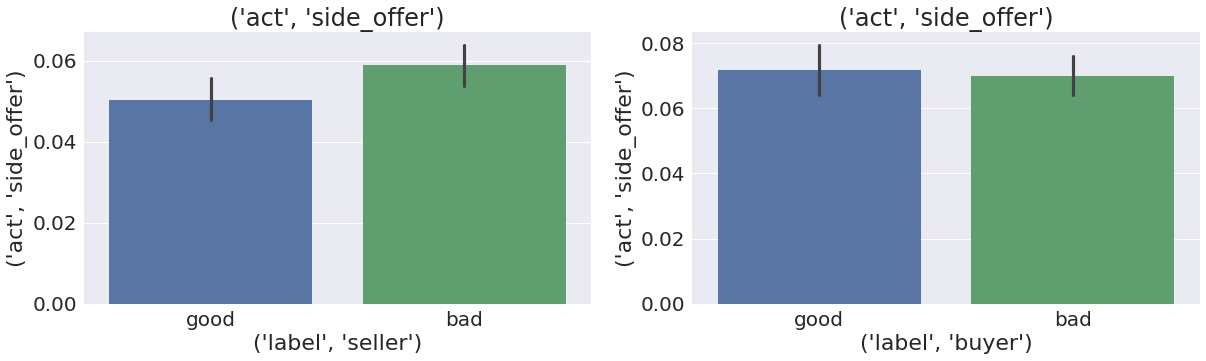

In [27]:
acts=['price_statement', 'price_question', 'reference', 'side_offer']
acts = [('act', a) for a in acts]
plot_good_vs_bad(data, acts, by_stage=False, normalization='utterance')

### % of speech acts over stages.

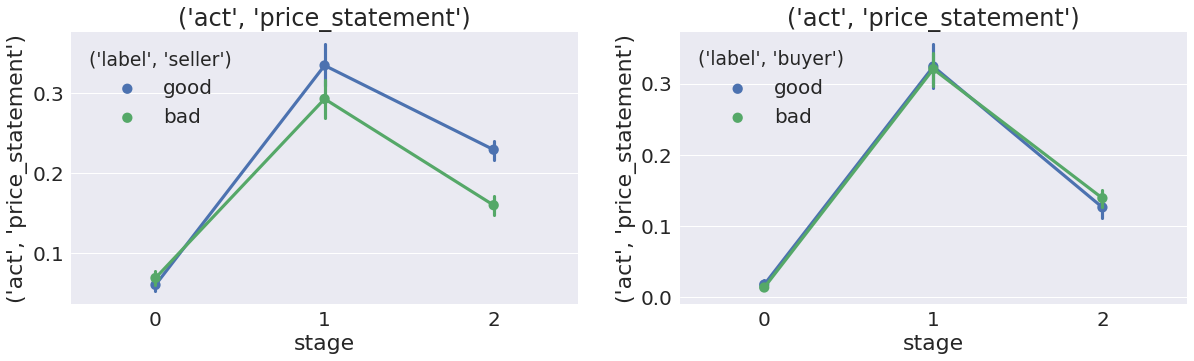

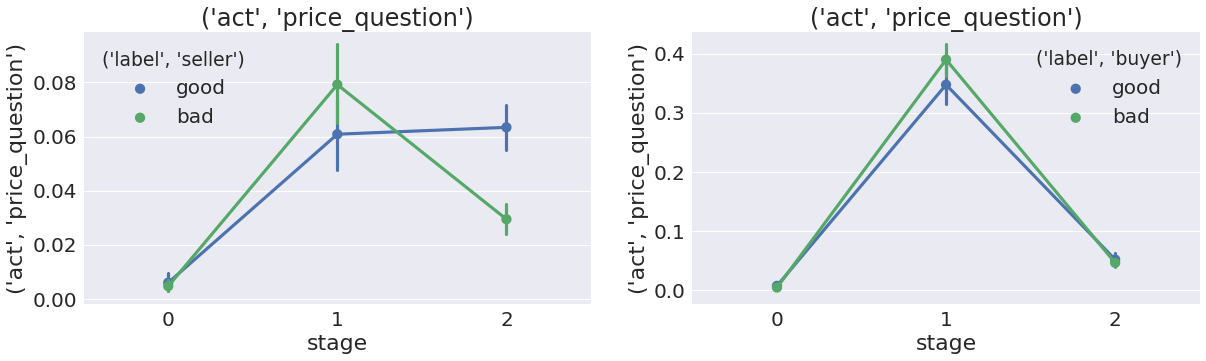

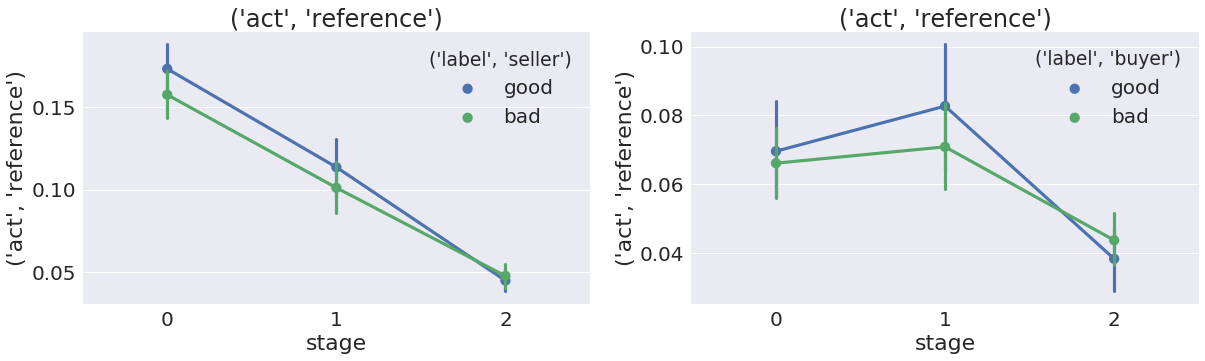

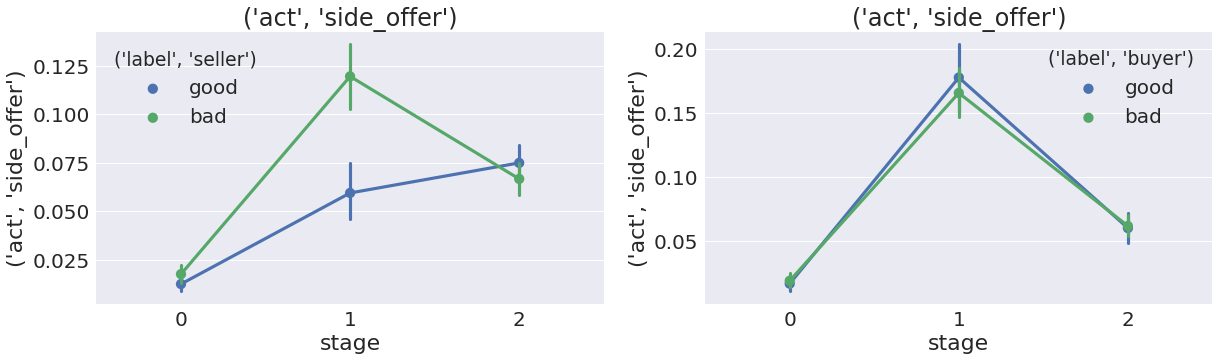

In [28]:
plot_good_vs_bad(data, acts, by_stage=True, normalization='utterance')

In [ ]:
analyzer.summarize_liwc(20)

In [185]:
example_dict = {ex.chat_id: ex for ex in analyzer.examples}
print example_dict['C_00a031e9c21345128fff7e53639a30c0']

----------------
Listing price: 2745
Role: seller
Price range: (None, 2745)
Title       This Gorgeous Home Won't be On The Market For Long .........
Category    housing
Price       2745
Images      housing/6114458238_0.jpg
Description 
CLEAN ! BIG HOUSE ! MOVE-IN SPECIAL!  Charm
Very Spacious Family Home Available For A Low Price
Awesome family home available for a low price
You're chance to take advantage of the lease with options on this newly listed home 小may not last long.
Several lease lengths to choose from  if you income qualify.
If  BAD CREDIT ??  OK. Don't throw your money away every month, lease with options is available get it  today!
This is simply best value on the mark for the price in this area.
BUYER
tokens: hi im interested in your home
keywords: Hi | im | home
SELLER
tokens: it 's a great home .
keywords: home
tokens: very clean !
keywords: 
BUYER
tokens: that 's great , however i noticed that other houses in the area are much cheaper , around the [$1500|1500.0] range